<a href="https://colab.research.google.com/github/CYBERCONQUEROR/AGENT/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# Download once
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load dataset
df = pd.read_csv(r"/content/Combined Data.csv")

# Drop unwanted column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Initialize tools
stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()                               # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)              # Remove punctuation & numbers
    tokens = text.split()                             # Tokenization
    tokens = [word for word in tokens if word not in stop_words]
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Handle missing values in 'statement' column by filling with empty strings
df['statement'] = df['statement'].fillna('')

# Apply preprocessing
df['clean_text'] = df['statement'].apply(preprocess_text)


# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])

print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


                                           statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

                                          clean_text  label  
0                                            oh gosh      0  
1  trouble sleeping confused mind restless heart ...      0  
2  wrong back dear forward doubt stay restless re...      0  
3  ive shifted focus something else im still worried      0  
4                im restless restless month boy mean      0  


In [ ]:
df['clean_text']

,clean_text
0,oh gosh
1,trouble sleeping confused mind restless heart ...
2,wrong back dear forward doubt stay restless re...
3,ive shifted focus something else im still worried
4,im restless restless month boy mean
...,...
53038,nobody takes seriously ive dealt depressionanx...
53039,selfishness dont feel good like dont belong wo...
53040,way sleep better cant sleep nights meds didnt ...
53041,public speaking tips hi give presentation work...


In [ ]:
df.to_csv("preprocessed_dataset.csv", index=False)


**CNN+BILSTM**

In [ ]:
# ==============================
# 1️⃣ IMPORTS
# ==============================
import time
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ==============================
# 2️⃣ LOAD DATASET
# ==============================
df = pd.read_csv("/content/preprocessed_dataset.csv")
df['clean_text'] = df['clean_text'].astype(str)

# ==============================
# 3️⃣ TOKENIZATION
# ==============================
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_data(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

encodings = tokenize_data(df['clean_text'])
labels = torch.tensor(df['label'].values)

# ==============================
# 4️⃣ TRAIN–VALIDATION SPLIT
# ==============================

train_idx, val_idx = train_test_split(
    range(len(labels)),
    test_size=0.2,
    random_state=42,
    stratify=labels
)
# train_idx, val_idx = train_test_split(
#     range(len(labels)), test_size=0.2, random_state=42
# )

train_encodings = {k: v[train_idx] for k, v in encodings.items()}
val_encodings   = {k: v[val_idx] for k, v in encodings.items()}

train_labels = labels[train_idx]
val_labels   = labels[val_idx]

# ==============================
# 5️⃣ DATASET CLASS
# ==============================
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset   = TextDataset(val_encodings, val_labels)

# ==============================
# 6️⃣ MODEL: CNN + BiLSTM
# ==============================

class CNN_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=128,
            kernel_size=3,
            padding=1
        )

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):

        x = self.embedding(input_ids)  # (batch, seq_len, embed_dim)

        x = x.permute(0, 2, 1)  # (batch, embed_dim, seq_len)

        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1)  # (batch, seq_len, features)

        lstm_out, _ = self.lstm(x)

        out = lstm_out[:, -1, :]  # last timestep

        out = self.dropout(out)

        return self.fc(out)


# ==============================
# 7️⃣ DEVICE INFO
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n🔍 Device Information")
print(f"🖥️ Device in use: {device}")

if device.type == "cuda":
    print(f"🚀 GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU not detected, using CPU")

# ==============================
# 8️⃣ INITIALIZE MODEL
# ==============================
vocab_size = tokenizer.vocab_size
embed_dim = 300
num_classes = len(df['label'].unique())

model = CNN_BiLSTM(vocab_size, embed_dim, num_classes)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
)
# scheduler.step(val_accs)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)

# ==============================
# 9️⃣ TRAINING LOOP WITH EARLY STOPPING
# ==============================
EPOCHS = 30            # max epochs
patience = 10          # early stopping patience
best_val_acc = 0
epochs_no_improve = 0

train_losses, val_losses = [], []
train_accs_list, val_accs_list = [], [] # Renamed to avoid confusion with single epoch accuracy

training_start_time = time.time()
print("\n🚀 Training started with Early Stopping...\n")

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    # ===== TRAIN =====
    model.train()
    train_total_loss = 0 # Initialize total_loss for training
    preds, true = [], []

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        labels_batch = batch["labels"].to(device)

        outputs = model(input_ids, None)
        loss = criterion(outputs, labels_batch)

        loss.backward()
        optimizer.step()

        train_total_loss += loss.item() # Accumulate training loss
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        true.extend(labels_batch.cpu().numpy())

    train_acc = accuracy_score(true, preds)
    train_losses.append(train_total_loss / len(train_loader))
    train_accs_list.append(train_acc) # Append single epoch accuracy to list

    # ===== VALIDATION =====
    model.eval()
    val_total_loss = 0 # Initialize total_loss for validation
    preds, true = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels_batch = batch["labels"].to(device)

            outputs = model(input_ids, None)
            loss = criterion(outputs, labels_batch)

            val_total_loss += loss.item() # Accumulate validation loss
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true.extend(labels_batch.cpu().numpy())

    val_acc = accuracy_score(true, preds)
    val_losses.append(val_total_loss / len(val_loader))
    val_accs_list.append(val_acc) # Append single epoch accuracy to list

    epoch_time = time.time() - epoch_start_time

    print(
        f"📘 Epoch {epoch+1} | "
        f"⏱️ {epoch_time:.2f}s | "
        f"📈 Train Acc: {train_acc:.4f} | "
        f"✅ Val Acc: {val_acc:.4f}"
    )

    # ===== EARLY STOPPING LOGIC =====
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Best model saved!\n")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epoch(s)\n")

    if epochs_no_improve >= patience:
        print("🛑 Early stopping triggered!")
        break

# ==============================
# 🔟 TOTAL TRAINING TIME
# ==============================
total_time = time.time() - training_start_time

print("\n🎉 Training completed!")
print(f"🏆 Best Validation Accuracy: {best_val_acc:.4f}")
print(f"⏳ Total training time: {total_time/60:.2f} minutes")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


🔍 Device Information
🖥️ Device in use: cuda
🚀 GPU Name: Tesla T4

🚀 Training started with Early Stopping...

📘 Epoch 1 | ⏱️ 13.67s | 📈 Train Acc: 0.5335 | ✅ Val Acc: 0.6101
💾 Best model saved!

📘 Epoch 2 | ⏱️ 10.54s | 📈 Train Acc: 0.6447 | ✅ Val Acc: 0.6769
💾 Best model saved!

📘 Epoch 3 | ⏱️ 16.94s | 📈 Train Acc: 0.7045 | ✅ Val Acc: 0.7082
💾 Best model saved!

📘 Epoch 4 | ⏱️ 10.83s | 📈 Train Acc: 0.7653 | ✅ Val Acc: 0.7284
💾 Best model saved!

📘 Epoch 5 | ⏱️ 10.70s | 📈 Train Acc: 0.8024 | ✅ Val Acc: 0.7358
💾 Best model saved!

📘 Epoch 6 | ⏱️ 12.76s | 📈 Train Acc: 0.8331 | ✅ Val Acc: 0.7445
💾 Best model saved!

📘 Epoch 7 | ⏱️ 10.80s | 📈 Train Acc: 0.8637 | ✅ Val Acc: 0.7418
⚠️ No improvement for 1 epoch(s)

📘 Epoch 8 | ⏱️ 10.78s | 📈 Train Acc: 0.8891 | ✅ Val Acc: 0.7399
⚠️ No improvement for 2 epoch(s)

📘 Epoch 9 | ⏱️ 10.81s | 📈 Train Acc: 0.9077 | ✅ Val Acc: 0.7391
⚠️ No improvement for 3 epoch(s)

📘 Epoch 10 | ⏱️ 10.77s | 📈 Train Acc: 0.9230 | ✅ Val Acc: 0.7262
⚠️ No improvement for

BERT+ BILSTM

In [3]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()

# preds = []
# true = []

# with torch.no_grad():
#     for batch in val_loader:
#         input_ids = batch["input_ids"].to(device)
#         labels_batch = batch["labels"].to(device)

#         outputs = model(input_ids, None)
#         # Corrected: Initialize preds as a list and use .append() or extend() with a list
#         preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
#         true.extend(labels_batch.cpu().numpy())

# all_preds = np.array(preds)
# all_true = np.array(true)

In [2]:
# # Get class names
# class_names = df['label'].unique()
# class_names = sorted(class_names)

# cm = confusion_matrix(all_true, all_preds)

# plt.figure(figsize=(8,6))
# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=class_names,
#     yticklabels=class_names
# )

# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix (CNN + BiLSTM)")
# plt.tight_layout()
# plt.savefig("confusion_matrix_CNN+BILSTM.png", dpi=300)
# plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['label'])

class_names = le.classes_

In [1]:
# report = classification_report(
#     true,
#     preds,
#     target_names=[str(c) for c in class_names],
#     output_dict=True
# )

# report_df = pd.DataFrame(report).transpose()

# # Plot as table
# plt.figure(figsize=(10,6))
# plt.axis('off')

# table = plt.table(
#     cellText=report_df.round(4).values,
#     colLabels=report_df.columns,
#     rowLabels=report_df.index,
#     loc='center',
#     cellLoc='center'
# )

# table.scale(1, 1.5)
# plt.title("Classification Report (CNN + BiLSTM)", pad=20)
# plt.tight_layout()
# plt.savefig("classification_report.png", dpi=300)
# plt.show()

In [ ]:
# import time
# import torch
# import torch.nn as nn
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizer, BertModel
# from torch.optim import AdamW
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # ==============================
# # 2️⃣ LOAD DATASET
# # ==============================
# df = pd.read_csv("/content/preprocessed_dataset.csv")
# # Ensure clean_text column is all strings
# df['clean_text'] = df['clean_text'].astype(str)


# # ==============================
# # 3️⃣ TOKENIZATION
# # ==============================
# MODEL_NAME = "bert-base-uncased"
# MAX_LEN = 128

# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# def tokenize_data(texts):
#     return tokenizer(
#         texts.tolist(),
#         padding=True,
#         truncation=True,
#         max_length=MAX_LEN,
#         return_tensors="pt"
#     )

# encodings = tokenize_data(df['clean_text'])
# labels = torch.tensor(df['label'].values)

# # ==============================
# # 4️⃣ TRAIN–VALIDATION SPLIT
# # ==============================
# train_idx, val_idx = train_test_split(
#     range(len(labels)), test_size=0.2, random_state=42
# )

# train_encodings = {k: v[train_idx] for k, v in encodings.items()}
# val_encodings   = {k: v[val_idx] for k, v in encodings.items()}

# train_labels = labels[train_idx]
# val_labels   = labels[val_idx]

# # ==============================
# # 5️⃣ DATASET CLASS
# # ==============================
# class TextDataset(Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {k: v[idx] for k, v in self.encodings.items()}
#         item["labels"] = self.labels[idx]
#         return item

#     def __len__(self):
#         return len(self.labels)

# train_dataset = TextDataset(train_encodings, train_labels)
# val_dataset   = TextDataset(val_encodings, val_labels)

# # ==============================
# # 6️⃣ MODEL: CNN + BiLSTM
# # ==============================

# class CNN_BiLSTM(nn.Module):
#     def __init__(self, vocab_size, embed_dim, num_classes):
#         super().__init__()

#         # Embedding layer
#         self.embedding = nn.Embedding(vocab_size, embed_dim)

#         # CNN layer
#         self.conv = nn.Conv1d(
#             in_channels=embed_dim,
#             out_channels=128,
#             kernel_size=3,
#             padding=1
#         )

#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool1d(kernel_size=2)

#         # BiLSTM
#         self.lstm = nn.LSTM(
#             input_size=128,
#             hidden_size=128,
#             bidirectional=True,
#             batch_first=True
#         )

#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(256, num_classes)

#     def forward(self, input_ids, attention_mask):

#         x = self.embedding(input_ids)  # (batch, seq_len, embed_dim)

#         x = x.permute(0, 2, 1)  # (batch, embed_dim, seq_len)

#         x = self.conv(x)
#         x = self.relu(x)
#         x = self.pool(x)

#         x = x.permute(0, 2, 1)  # (batch, seq_len, features)

#         lstm_out, _ = self.lstm(x)

#         out = lstm_out[:, -1, :]  # last time step

#         out = self.dropout(out)

#         return self.fc(out)


# # ==============================
# # 6️⃣ MODEL: BERT + BiLSTM
# # ==============================
# # class BertBiLSTM(nn.Module):
# #     def __init__(self, num_classes):
# #         super().__init__()

# #         self.bert = BertModel.from_pretrained("bert-base-uncased")
# #         self.lstm = nn.LSTM(
# #             input_size=768,
# #             hidden_size=128,
# #             num_layers=1,
# #             bidirectional=True,
# #             batch_first=True
# #         )
# #         self.dropout = nn.Dropout(0.3)
# #         self.fc = nn.Linear(256, num_classes)

# #     def forward(self, input_ids, attention_mask):
# #         bert_output = self.bert(
# #             input_ids=input_ids,
# #             attention_mask=attention_mask
# #         )

# #         sequence_output = bert_output.last_hidden_state
# #         lstm_out, _ = self.lstm(sequence_output)

# #         pooled_output = torch.mean(lstm_out, dim=1)
# #         pooled_output = self.dropout(pooled_output)

# #         return self.fc(pooled_output)

# # ==============================
# # 6️⃣ MODEL: BERT ONLY
# # ==============================


# # class BertOnly(nn.Module):
# #     def __init__(self, num_classes):
# #         super().__init__()
# #         self.bert = BertModel.from_pretrained("bert-base-uncased")
# #         self.dropout = nn.Dropout(0.3)
# #         self.fc = nn.Linear(768, num_classes)

# #     def forward(self, input_ids, attention_mask):
# #         output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
# #         pooled = output.pooler_output
# #         return self.fc(self.dropout(pooled))


# # ==============================
# # 7️⃣ DEVICE & GPU INFO
# # ==============================
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print("\n🔍 Device Information")
# print(f"🖥️ Device in use: {device}")

# if device.type == "cuda":
#     print(f"🚀 GPU Name: {torch.cuda.get_device_name(0)}")
#     print(f"🔥 CUDA Version: {torch.version.cuda}")
#     print(f"💾 Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
# else:
#     print("⚠️ GPU not detected, using CPU")

# print("\n🔤 Tokenization Details")
# print(f"📌 Tokenizer: {MODEL_NAME}")
# print(f"📏 Max Length: {MAX_LEN}")
# print(f"🧠 Training samples: {len(train_labels)}")
# print(f"🧠 Validation samples: {len(val_labels)}")



# # ==============================
# # 8️⃣ TRAINING SETUP
# # ==============================

# vocab_size = tokenizer.vocab_size
# embed_dim = 300

# model = CNN_BiLSTM(
#     vocab_size=vocab_size,
#     embed_dim=embed_dim,
#     num_classes=len(df['label'].unique())
# )
# model.to(device)

# # model.to(device)
# # model = BertBiLSTM(num_classes=len(df['label'].unique()))
# # model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# EPOCHS = 10
# batch_size = 32

# # optimizer = AdamW(model.parameters(), lr=2e-5) #lr=1e-5
# criterion = nn.CrossEntropyLoss()

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # batch_size=8
# val_loader   = DataLoader(val_dataset, batch_size=16)



# # ==============================
# # 9️⃣ TRAINING LOOP (TIME + EMOJIS)
# # ==============================
# EPOCHS = 5
# train_losses, val_losses = [], []
# train_accs, val_accs = [], []

# training_start_time = time.time()
# print("\n🚀 Training started...\n")

# for epoch in range(EPOCHS):
#     epoch_start_time = time.time()

#     model.train()
#     total_loss, preds, true = 0, [], []

#     for batch in train_loader:
#         optimizer.zero_grad()

#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels_batch = batch["labels"].to(device)

#         outputs = model(input_ids, attention_mask)
#         loss = criterion(outputs, labels_batch)

#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
#         true.extend(labels_batch.cpu().numpy())

#     train_losses.append(total_loss / len(train_loader))
#     train_accs.append(accuracy_score(true, preds))

#     # ===== VALIDATION =====
#     model.eval()
#     total_loss, preds, true = 0, [], []

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels_batch = batch["labels"].to(device)

#             outputs = model(input_ids, attention_mask)
#             loss = criterion(outputs, labels_batch)

#             total_loss += loss.item()
#             preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
#             true.extend(labels_batch.cpu().numpy())

#     val_losses.append(total_loss / len(val_loader))
#     val_accs.append(accuracy_score(true, preds))

#     epoch_time = time.time() - epoch_start_time

#     print(
#         f"📘 Epoch {epoch+1}/{EPOCHS} | "
#         f"⏱️ {epoch_time:.2f}s | "
#         f"📉 Train Loss: {train_losses[-1]:.4f} | "
#         f"📈 Train Acc: {train_accs[-1]:.4f} | "
#         f"✅ Val Acc: {val_accs[-1]:.4f}"
#     )

#     if device.type == "cuda":
#         print(f"💾 GPU Memory Used: {torch.cuda.memory_allocated() / 1e9:.2f} GB\n")

# # ==============================
# # 🔟 TOTAL TRAINING TIME
# # ==============================
# total_training_time = time.time() - training_start_time

# print("\n🎉 Training completed!")
# print(f"⏳ Total training time: {total_training_time/60:.2f} minutes")

Accuracy Plot

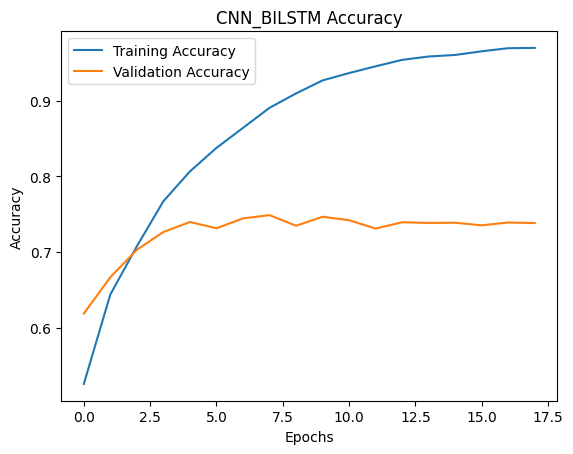

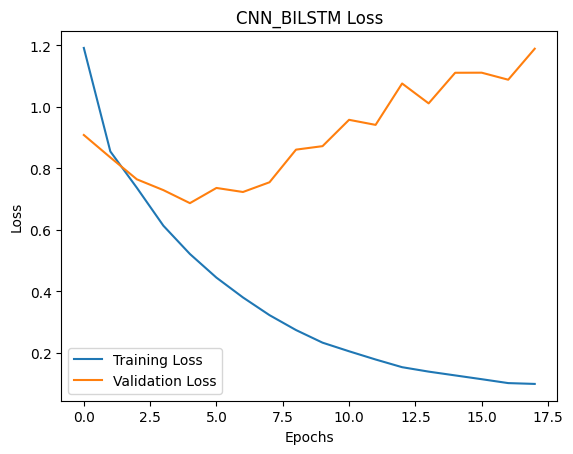

In [ ]:
import matplotlib.pyplot as plt

# ---- Accuracy Plot ----
plt.figure()
plt.plot(train_accs_list, label="Training Accuracy")
plt.plot(val_accs_list, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN_BILSTM Accuracy")
plt.legend()

plt.savefig("CNN_BILSTM_ACCCURACY.png", dpi=300, bbox_inches="tight")
plt.show()


# ---- Loss Plot ----
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN_BILSTM Loss")
plt.legend()

plt.savefig("CNN_BILSTM_LOSS.png", dpi=300, bbox_inches="tight")
plt.show()

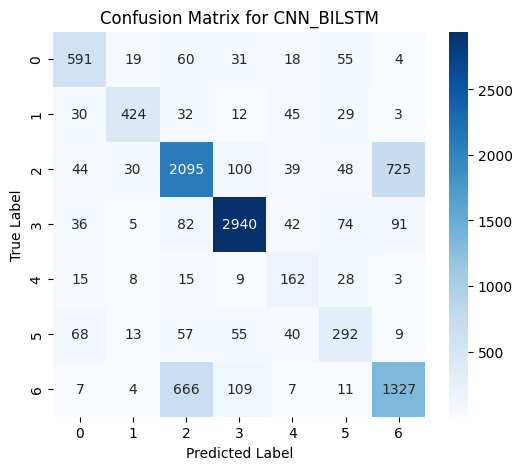

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for CNN_BILSTM")
plt.savefig("confusion_matrix_CNN_BILSTM.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])

# Save class names in correct order
class_names = le.classes_.tolist()
class_names

['Anxiety',
 'Bipolar',
 'Depression',
 'Normal',
 'Personality disorder',
 'Stress',
 'Suicidal']

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(
    all_true,
    all_preds,
    target_names=class_names,
    digits=4,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()


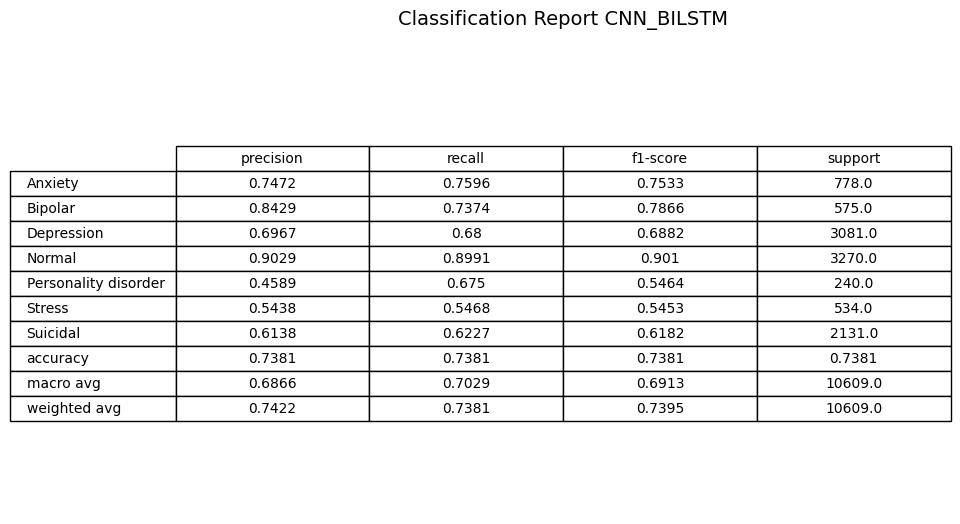

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.axis('off')

table = plt.table(
    cellText=report_df.round(4).values,
    colLabels=report_df.columns,
    rowLabels=report_df.index,
    loc='center',
    cellLoc='center'
)

table.scale(1, 1.5)

plt.title("Classification Report CNN_BILSTM", fontsize=14, pad=20)

plt.savefig("classification_report_CNN_BILSTM.png", dpi=300, bbox_inches='tight')
plt.show()
